In [2]:
%load_ext autoreload

%autoreload 2
from multiprocessing import Pool
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
#import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as likelihood_mr
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis
import CL_Mass_richness_relation as mr

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [3]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [7]:
data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
dataBPZ = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_BPZ.pkl', allow_pickle=True)
dataflex = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_flex.pkl', allow_pickle=True)

In [8]:
data

{'stacked profile': <Table length=28>
   z_mean   ...
  float32   ...
 ---------- ...
 0.25773725 ...
 0.25914037 ...
 0.26309174 ...
 0.26843795 ...
 0.35263056 ...
 0.35756844 ...
  0.3493773 ...
 0.34494773 ...
 0.45536184 ...
 0.45257512 ...
        ... ...
 0.64811003 ...
  0.6537457 ...
 0.74844944 ...
 0.75512993 ...
 0.74613744 ...
  0.7533339 ...
  0.8916461 ...
  0.8906239 ...
  0.9040735 ...
 0.89012355 ...,
 'stacked covariance': <Table length=28>
   z_mean    obs_mean  ...                gt_random                
  float32    float32   ...             float64[400,15]             
 ---------- ---------- ... ----------------------------------------
 0.25773725  26.190575 ...  71227082716314.31 .. 1730607601733.3247
 0.25914037  48.263638 ...   77784011768831.08 .. 3282616435310.436
 0.26309174  80.136406 ... 133691707576474.69 .. 1038512800872.4995
 0.26843795  138.82195 ... 111054419956816.88 .. 13331398684821.818
 0.35263056   25.84348 ... 59687326186064.484 .. 24649931916

In [118]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

0.35263056
0.8916461


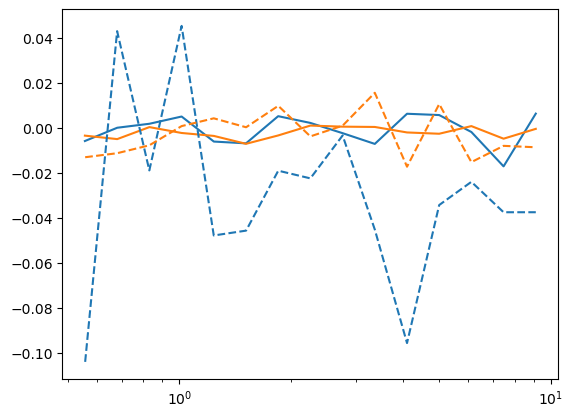

In [21]:
index = 1
mask =( data['stacked profile']['obs_mean']>20)*( data['stacked profile']['obs_mean']<45)
print(dataBPZ['stacked profile']['z_mean'][mask][index])
b1 = (dataBPZ['stacked profile']['gt'][mask][index] - data['stacked profile']['gt'][mask][index])/data['stacked profile']['gt'][mask][index]
b2 = (dataflex['stacked profile']['gt'][mask][index] - data['stacked profile']['gt'][mask][index])/data['stacked profile']['gt'][mask][index]
plt.plot(data['stacked profile']['radius'][mask][index],b1, 'C0')
plt.plot(data['stacked profile']['radius'][mask][index],b2, 'C1')

index = 6
print(dataBPZ['stacked profile']['z_mean'][mask][index])
b1 = (dataBPZ['stacked profile']['gt'][mask][index] - data['stacked profile']['gt'][mask][index])/data['stacked profile'][mask]['gt'][index]
b2 = (dataflex['stacked profile']['gt'][mask][index] - data['stacked profile']['gt'][mask][index])/data['stacked profile'][mask]['gt'][index]
plt.plot(data['stacked profile']['radius'][mask][index],b1, '--C0')
plt.plot(data['stacked profile']['radius'][mask][index],b2, '--C1')
plt.xscale('log')